# Preprocesamiento de imágenes

## Carga de etiquetas

In [1]:
import pandas as pd

En primer lugar, cargamos las etiquetas del repositorio, reorganizazmos las columnas y convertimos las categorías.

In [2]:
ruta_INbreast = 'INBreast/'
etiquetas = pd.read_csv(ruta_INbreast + '\\INbreast.csv', sep = ';')
etiquetas = etiquetas.drop(columns = ['Patient ID', 'Patient age', 'Acquisition date', 'ACR'])
etiquetas['Case ID'] = etiquetas['File Name'].astype(str).str[:6] + '_' + etiquetas['Laterality']
etiquetas = etiquetas.drop(columns = ['Laterality']).sort_values(by = ['Case ID'])
nuevas_cat = {0: 'incompleto', 1: 'benigno', 2: 'benigno', 3: 'control', 4: 'actuación', 5: 'actuación', 6: 'maligno'}
etiquetas['Bi-Rads'] = etiquetas['Bi-Rads'].astype(str).str[0].astype(int).map(nuevas_cat).astype('category')
etiquetas.head()

,View,File Name,Bi-Rads,Case ID
331,CC,20586934,actuación,205869_L
332,MLO,20586986,actuación,205869_L
330,CC,20586908,benigno,205869_R
333,MLO,20586960,benigno,205869_R
346,CC,20587054,actuación,205870_R


Mostramos por pantalla la distribución de casos por categorías.

<AxesSubplot:>

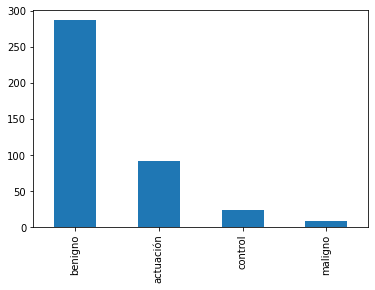

In [3]:
etiquetas['Bi-Rads'].value_counts().plot(kind = 'bar')

## Carga de rutas de ficheros

In [4]:
import random
import glob2
import os

Listamos todos los ficheros de mamografías y los incorporamos en el dataframe.

In [5]:
ruta_img = ruta_INbreast + 'AllDICOMs\\'
filepaths = pd.DataFrame([os.path.basename(x) for x in glob2.glob(ruta_img + '*.dcm')], columns = ['File Path'])
filepaths['File Name'] = filepaths['File Path'].astype(str).str[:8].astype(int)
df_INbreast = etiquetas.merge(filepaths, on = 'File Name').drop(columns = ['File Name']).rename(columns = {'File Path': 'File Name'})
df_INbreast.head()

,View,Bi-Rads,Case ID,File Name
0,CC,actuación,205869_L,20586934_6c613a14b80a8591_MG_L_CC_ANON.dcm
1,MLO,actuación,205869_L,20586986_6c613a14b80a8591_MG_L_ML_ANON.dcm
2,CC,benigno,205869_R,20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm
3,MLO,benigno,205869_R,20586960_6c613a14b80a8591_MG_R_ML_ANON.dcm
4,CC,actuación,205870_R,20587054_b6a4f750c6df4f90_MG_R_CC_ANON.dcm


Descartamos un porcentaje de casos benignos para balancear un poco el dataset.

<AxesSubplot:>

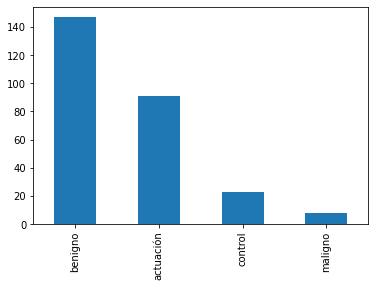

In [6]:
random.seed(2021)
fraccion = .5
casos = df_INbreast[['Case ID', 'Bi-Rads']].drop_duplicates(subset = ['Case ID'])
casos = casos[casos['Bi-Rads'] == 'benigno'].sample(frac = fraccion)['Case ID']
df_INbreast = df_INbreast[~df_INbreast['Case ID'].isin(casos)]
df_INbreast['Bi-Rads'].value_counts().plot(kind = 'bar')

## Carga de imágenes

In [7]:
import numpy as np
from skimage import io
from skimage import color
from skimage.filters import difference_of_gaussians
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Definimos las funciones auxiliares necesarias para la carga de imágenes.

In [8]:
def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    image = cv2.resize(image, (1024, 1024), interpolation = cv2.INTER_CUBIC)
    return image

def visualize(image):
    plt.figure(figsize = (10, 10))
    plt.axis('off')
    plt.imshow(image)
    return

def crop(img):
    """
    Crop ROI from image.
    """

    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0).astype('uint8')
    _, breast_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    return img[y:y+h, x:x+w]

def zero_padding(img, size):
    """
    Zero padding to (size x size).
    """

    top = round((size - img.shape[0])/2)
    bottom = size - (img.shape[0] + top)
    left = round((size - img.shape[1])/2)
    right = size - (img.shape[1] + left)

    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, 0)
    
    return img

def multi_dog(img):
    img = np.dstack((difference_of_gaussians(img, 2), difference_of_gaussians(img, 4), difference_of_gaussians(img, 8)))
    
    return cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX).astype(int)

Cargamos las imágenes asociadas al dataset generado en el apartado anterior.

In [9]:
imgs_loaded = pd.DataFrame(columns =  ['File Name', 'Image Array'])
for img_path in df_INbreast['File Name']:
    img_array = read_image(ruta_img + img_path).astype(float)
    img_array *= 255.0 / img_array.max()
    img_array = multi_dog(zero_padding(crop(img_array), 1024))
    imgs_loaded = imgs_loaded.append(pd.DataFrame([[img_path, img_array]], columns = ['File Name', 'Image Array']), ignore_index = True)
    
df_INbreast = df_INbreast.merge(imgs_loaded, on = 'File Name')
df_INbreast.shape

<ipython-input-8-b3d7c7a30c1d>:12: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image = color.rgb2gray(image)


(269, 5)

## Data augmentation

In [10]:
import albumentations as A

Definición de funciones auxiliares.

In [11]:
def vertFlip(img):
    transform = A.VerticalFlip(p = 1)
    return transform(image = img)['image']

<AxesSubplot:>

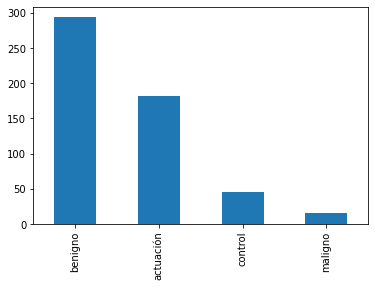

In [12]:
for index, row in df_INbreast.iterrows():
    new_row = pd.DataFrame([[str(row['View']), str(row['Bi-Rads']), str(row['Case ID'] + '_Flip'), '-', vertFlip(row['Image Array'])]], columns = list(df_INbreast.columns))
    df_INbreast = df_INbreast.append(new_row, ignore_index = True)
    
df_INbreast['Bi-Rads'].value_counts().plot(kind = 'bar')

## Almacén de datos en fichero externo

In [13]:
df_INbreast.to_pickle('./df_INbreast.pkl')

## Visualización del resultado final

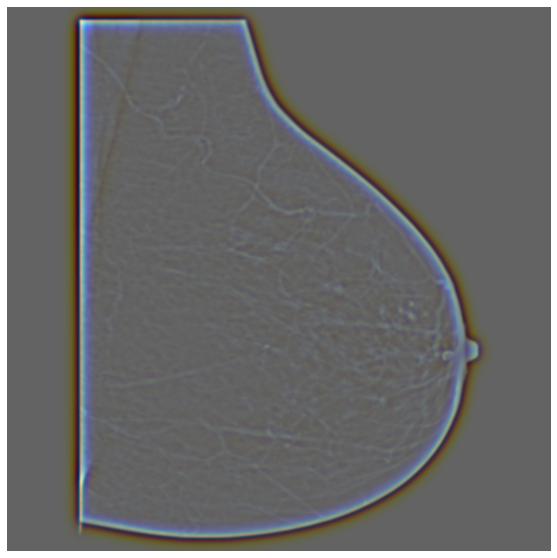

In [14]:
visualize(df_INbreast['Image Array'][10])

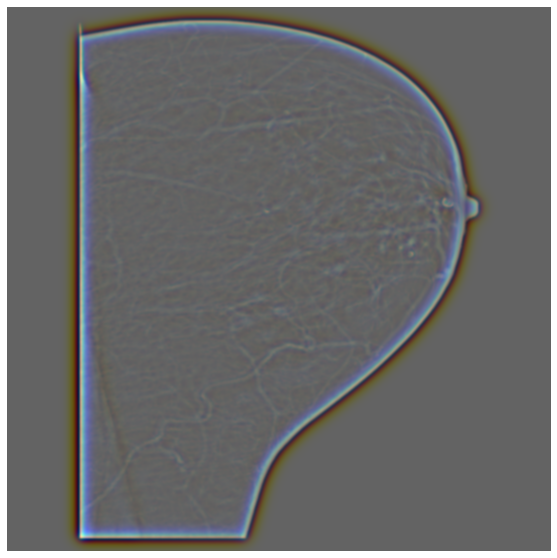

In [15]:
visualize(df_INbreast['Image Array'][10 + int(df_INbreast.shape[0]/2)])